

> **This project aims to predict call volume for Seattle Fire Department. To this end, call dataset from data.seattle.gov and weather data from World Weather Online are used to train the models with previous years' data to predict current year. Different components of this ML Pipeline is available as scripts in GitHub repository.**

> **There are explanations and clarifications on the design and assumptions throughout this notebook. For the usage of scripts, check the repository.**




In [22]:
!pip install sodapy wwo_hist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
#@title DataSet

# training, preprocessing, testing, model
# %%writefile preprocess.py
import matplotlib 
import xgboost as xgb
import pandas as pd
import numpy as np
import argparse

from matplotlib import pyplot as plt
from sodapy import Socrata
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from wwo_hist import retrieve_hist_data


class DataSet:
    """Dataset class with several methods to process pandas.DataFrame."""

    def __init__(self, df):
        """
        Constructs DataSet with pandas.DataFrame attribute.

        Parameters
        ----------
            df: pandas.DataFrame
                Dataframe to be processed.
        """
        self.df =  df

    def add_lags(self, target):
        """
        Adds lag features to the call data, using moving window average.

        Parameters
        ----------
            target: str
                Target variable column name in call dataframe.
        """
        self.df["12h_mean"] = self.df[target].rolling(12).mean()
        self.df["24h_mean"] = self.df[target].rolling(24).mean()
        self.df["36h_mean"] = self.df[target].rolling(36).mean()
        self.df["w_mean"] = self.df[target].rolling(7*24).mean()
        self.df["m_mean"] = self.df[target].rolling(30*24).mean()
        self.df["y_mean"] = self.df[target].rolling(365*24).mean()
        
    def clear_dups(self):
        """
        Clears the duplicates from the call data. 
        
        Note that, there are some calls with same time stamp, however they are 
        not discarded since the adress information is different for each.
        """
        self.df.drop(columns=['report_location'], inplace=True, errors='ignore')
        # no duplicates in the dataset        
        if self.df[self.df.duplicated(keep=False)].count().sum() :
            self.df.drop_duplicates()

    def drop_unrelated(self):
        """
        Drops unrelated variables from the dataframe such as lat/lon/adress.
        """
        self.df.drop(
            columns=['latitude', 'longitude', 
                    'incident_number', 'type', 'address'], 
            inplace=True,
            errors='ignore'
        )
              
    def add_time_features(self):
        """
        Adds time features to the dataframe utilizing `pandas` datetime
        attributes.
        """
        # changing datetime name for convinience
        self.df.rename(columns={"datetime":"stamp"}, inplace=True)
        self.df.stamp = pd.to_datetime(self.df.stamp, infer_datetime_format=True)

        # time series features, useful as training features
        self.df['hour'] = self.df['stamp'].dt.hour
        self.df['dayofweek'] = self.df['stamp'].dt.dayofweek
        self.df['quarter'] = self.df['stamp'].dt.quarter
        self.df['month'] = self.df['stamp'].dt.month
        self.df['year'] = self.df['stamp'].dt.year
        self.df['dayofyear'] = self.df['stamp'].dt.dayofyear
        self.df['dayofmonth'] = self.df['stamp'].dt.day
        self.df['weekofyear'] = self.df['stamp'].dt.isocalendar().week.astype('int64')

        # adding hour resolution 
        self.df.loc[:, "hour_only"] = pd.to_datetime(
            self.df.stamp.dt.strftime("%Y-%m-%d %H:00:00")
        )

        self.df.set_index('stamp', inplace=True)
        self.df.sort_index(inplace=True)       
 
    def process_weather(self):
        """Processes weather data to make it ready to merge with call data."""

        self.df.rename(columns={"date_time":"stamp"}, inplace=True)
        self.df.stamp = pd.to_datetime(self.df.stamp, infer_datetime_format=True)
        self.df = self.df.astype(
            {'windspeedKmph':'float32', 'tempC':'float32'}
        )
        self.df.set_index('stamp', inplace=True)
        self.df.sort_index(inplace=True)

    def check_missing_hours(self):
        """
        Checks missing hours in the data and fills the gaps using linear
        interpolation.
        """
        N_hours = pd.date_range(start=self.df.index.min(), 
                                end=self.df.index.max(), freq='H')
        df_reindexed = self.df.reindex(N_hours)
        n_hours = N_hours.difference(self.df.index.unique()).values.shape[0]
        if n_hours > 0:
            print(f"Missing {n_hours} hours of data. Filling the gaps ....")
            self.df = df_reindexed.interpolate(method = 'linear')
    

def download_data(start=None, end=None):
    """
    Downloads 911 Call data and weather data for Seattle.
    
    Parameters
    ----------
        start: str
            Should be in %Y-%M-%D format.
        end: str
            Should be in %Y-%M-%D format.

    Returns
    -------
        call_df: pandas.DataFrame 
            Dataframe of the 911 call data.
        weather_df: pandas.DataFrame
            Dataframe of the weather data of Seattle.    
    """    
    # Downloading both call data and weather data from respective sources
    client = Socrata("data.seattle.gov", None)
    if start and end:
        print("Downloading partial 911 Call data from data.seattle.gov .....")
        query = f"datetime BETWEEN '{start}' AND '{end}'"
        call_data = client.get("kzjm-xkqj", where=query, limit=int(2e6))  

    else:
        print("Downloading full 911 Call data from data.seattle.gov .....")
        call_data = client.get("kzjm-xkqj", limit=int(2e6))   

    print("911 Call Data is downloaded!")

    # convert to DataFrame
    call_df = pd.DataFrame.from_records(call_data).iloc[:, :7]
    # saving data to ease usage
    call_df.to_csv("seattle_call.csv", index=False)

    # downloading weather data
    api_key = 'e63769263db649d7af9180013222309'
    freq = 1
    start_date = '2008-07-01'   # data available from this date on
    end_date = str(pd.Timestamp.now().date())
    location_list = ['seattle']
    print("Downloading weather data from WorldWeatherOnline .....")

    if start and end:
        print('Setting start and end dates for weather data ....')
        start_date = start
        end_date = end

    wwo_df = retrieve_hist_data(
        api_key,
        location_list,
        start_date,
        end_date,
        freq,
        location_label = False,
        export_csv = False,
        store_df = True
    );      

    weather_df = wwo_df[0][['date_time', 'tempC', \
                            'windspeedKmph']]

    print("Weather data is downloaded!")
    # saving data to ease usage
    weather_df.to_csv("weather_data.csv", index=False)

    return call_df, weather_df


def get_data_ready(start=None, end=None, download=False):
    """
    Processes data by using DataSet class methods and returns a DataFrame.

    Parameters
    ----------
        start: str
            Should be in %Y-%M-%D format.
        end: str
            Should be in %Y-%M-%D format.
        download: boolean
            Set True to downlaod the call and weather data. Note that it takes
            quite long time.

    Returns
    -------
        train_df: pandas.DataFrame
            DataFrame ready to use for training/validation.
    """
    
    if not download:
        # reading data since downloading takes very long time
        print("Loading data from current folder ....")
        try:
            call_df = pd.read_csv('seattle_call.csv') 

            weather_df = pd.read_csv(
                'weather_data.csv', 
                usecols=['date_time', 'tempC', 'windspeedKmph']
            )   
        except OSError as err:
            print(err)
            print('Downloading call and weather data ....')
            call_df, weather_df = download_data(start, end)

    else:     
        print('Downloading call and weather data ....')
        call_df, weather_df = download_data(start, end)   
         
    # Preprocessing the data with DataSet class methods
    call_ds = DataSet(call_df)
    call_ds.clear_dups()
    call_ds.drop_unrelated()
    call_ds.add_time_features()

    weather_ds = DataSet(weather_df)
    weather_ds.clear_dups()
    weather_ds.process_weather()

    hourly_calls = call_ds.df.hour_only.value_counts().astype('float32').sort_index()
    # daily_calls = call_ds.df.day_only.value_counts().astype('float32').sort_index()

    merged_df = call_ds.df\
        .reset_index()\
        .merge(weather_ds.df, left_on='hour_only', right_on='stamp', how='left')
    merged_df.set_index('stamp', inplace=True)

    target = 'calls'
    hourly_calls.name = target

    train_ds = DataSet(merged_df)
    train_ds.df = train_ds.df\
        .merge(hourly_calls, left_on='hour_only', right_index=True)\
        .drop_duplicates()

    train_ds.add_lags(target)
    train_ds.df.set_index('hour_only', inplace=True)        
    train_ds.check_missing_hours()        
    train_df = train_ds.df

    if start and end:   # when the full data available but trim required
        train_df = train_df[(train_df.index >= start) & (train_df.index < end)]

    return train_df


In [24]:
#@title Training
# %%writefile train.py
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.feature_selection import RFE


def select_features(model, df, n_features=None, target='calls'):
    """
    Implements Recursive Feature Elimination and returns selected feature 
    indices.

    Parameters
    ----------
        model: XGBRegressor() instance
        df: pandas.DataFrame
        n_features: int
            Number of features to keep.
        target: str
            Target variable column name in df.        

    Returns
    -------
        indices: array
            Selected feature indices to filter the dataset.
    """

    rfe = RFE(model, n_features_to_select=n_features, step=1, verbose=0, 
              importance_getter='auto')

    features = df.drop(columns=[target]).columns
    
    X_train = df[features]
    y_train = df[target]

    # using recursive feature elimination to select best features
    rfe.fit(X_train, y_train)
    indices = rfe.support_

    return indices


def train(df, target=None, cv=False, select_feat=False):
    """
    Trains XGBRegressor() instance. Supports k-fold cross-validation, but for
    time series, utilizing TimeSeriesSplit from sklearn, and Recursive Feature
    Elimination (RFE) algorithm for feature selection.

    Parameters
    ----------
        df: pandas.DataFrame
        target: str
            Target variable column name in df.
        cv: boolean
            Set True for using k-fold cross-validation.
        select_feat: boolean
            Set True for using RFE algorithm.

    Returns
    -------
        model: trained XGBRegressor() instance
        y_preds, preds: array
            Predictions of single test set (y_preds), or predictions for each 
            fold if cv=True (preds).
        scores: array
            Scores for each fold if cv=True.
        test: pandas.DataFrame
            Test/validation set that is used for validation RMSE calculation.    
    """
    features = df.drop(columns=[target]).columns
    # XGB will be used for regression
    model = xgb.XGBRegressor(n_estimators=1000)

    if cv:      # cross-validation for time series 
        # setting test size to 1 year hours
        splitter = TimeSeriesSplit(n_splits=5, test_size=24*365*1)

        fold = 0
        preds = list()
        scores = list()
        for train_idx, val_idx in splitter.split(df):
            train = df.iloc[train_idx]
            test = df.iloc[val_idx]

            X_train = train[features]
            y_train = train[target]
            X_test = test[features]   
            y_test = test[target]
            
            model.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    early_stopping_rounds=50,
                    verbose=100)

            y_pred = model.predict(X_test)
            preds.append(y_pred)
            score = np.sqrt(mean_squared_error(y_test, y_pred))
            scores.append(score)

        print(f'Score across folds {np.mean(scores):0.4f}')
        print(f'Fold scores:{scores}')

        return model, preds, scores

    else:
        # training without cross-validation, split 1 train/test
        splitter = TimeSeriesSplit(n_splits=2, test_size=24*365*1)        
        _, indices = splitter.split(df)

        train = df.iloc[indices[0]]
        test = df.iloc[indices[1]]
                
        if select_feat:     # to use RFE to select best features
            indices = select_features(model, df)
            features = features[indices]

        X_train = train[features]
        y_train = train[target]
        X_test = test[features]   
        y_test = test[target]


        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                early_stopping_rounds=50,
                verbose=100)

        y_pred = model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'RMSE: {score}')
    
        return model, y_pred, test

> **Getting DataFrame using the get_data_ready() function. It returns whole dataset prior to split. train() function also splits data if the dates are given.**



In [18]:
start = '2018-09-15'
end = '2022-09-15'

In [25]:
train_df = get_data_ready(download=True)

911 Call Data is downloaded!


Retrieving weather data for seattle


Currently retrieving data for seattle: from 2008-07-01 to 2008-07-31
Time elapsed (hh:mm:ss.ms) 0:00:01.124767
Currently retrieving data for seattle: from 2008-08-01 to 2008-08-31
Time elapsed (hh:mm:ss.ms) 0:00:02.189760
Currently retrieving data for seattle: from 2008-09-01 to 2008-09-30
Time elapsed (hh:mm:ss.ms) 0:00:03.059188
Currently retrieving data for seattle: from 2008-10-01 to 2008-10-31
Time elapsed (hh:mm:ss.ms) 0:00:04.126770
Currently retrieving data for seattle: from 2008-11-01 to 2008-11-30
Time elapsed (hh:mm:ss.ms) 0:00:04.968968
Currently retrieving data for seattle: from 2008-12-01 to 2008-12-31
Time elapsed (hh:mm:ss.ms) 0:00:06.081253
Currently retrieving data for seattle: from 2009-01-01 to 2009-01-31
Time elapsed (hh:mm:ss.ms) 0:00:06.964979
Currently retrieving data for seattle: from 2009-02-01 to 2009-02-28
Time elapsed (hh:mm:ss.ms) 0:00:08.368872
Currently retrieving data for seattle: from

> **Empty rows are the past weather data, and rolling window means which are inherent.**

In [26]:
train_df.isna().sum()


hour                 0
dayofweek            0
quarter              0
month                0
year                 0
dayofyear            0
dayofmonth           0
weekofyear           0
tempC            40743
windspeedKmph    40743
calls                0
12h_mean            11
24h_mean            23
36h_mean            35
w_mean             168
m_mean             721
y_mean            8793
dtype: int64

# Data Analysis and Clarification of the Feature Choices

> **Hourly and daily call volumes are plotted to understand the dataset in a clearer way. There are some unusual peaks which seems random. However, there are also some peaks which shows cyclic behaviour like occuring around new year eve.**

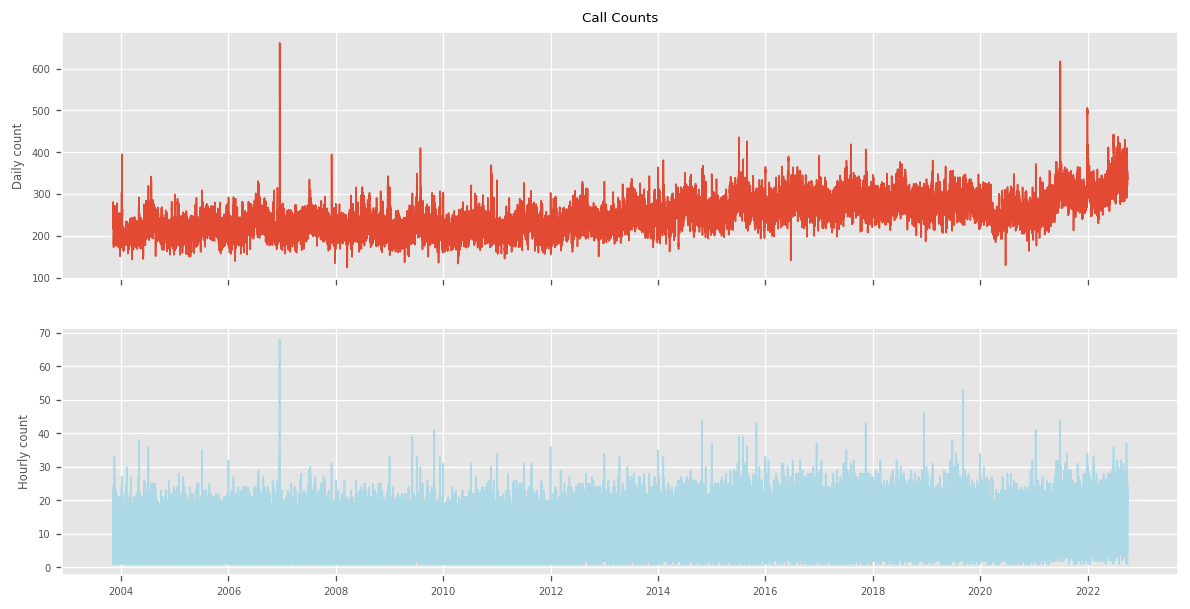

In [51]:
# plotting daily and hourly call data
matplotlib.rcParams['figure.dpi'] = 120
plt.style.use('ggplot')

hourly_calls = train_df.calls
daily_calls = hourly_calls.rolling(24).sum()

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
axs[0].plot(daily_calls, lw=1)
axs[0].set_ylabel('Daily count', fontsize=7)

axs[1].plot(hourly_calls, color='lightblue', lw=1)
axs[1].set_ylabel('Hourly count', fontsize=7)
axs[0].set_title('Call Counts', fontsize=8)
[ax.tick_params(axis='both', which='major', labelsize=6) for ax in axs];



> **Trend and seasonality analysis is conducted to get a more detailed picture of the call volume and an idea about possible feature candidates.**




In [52]:
from matplotlib.colorbar import constrained_layout
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt


def seasonal_analysis(df, target ,period):
    """
    Conducts seasonal analysis using seasonal_decompose(),
    and plots resulting components. Also plots autocorrelation
    and monthly seasonality data.

    Parameters
    ----------
    df: pandas.DataFrame
        Should include target variable.
    target: str
        Target variable column name in df.
    period: int
        Period value for seasonal decomposition. 365 means 365 days = yearly.
    """ 
    decomposed = seasonal_decompose(df[target], model="additive", period=period)
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    residual = decomposed.resid
    
    plt.style.use('ggplot')
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
    axs[-1].set_xlabel('Date', fontsize=7)

    fig.tight_layout() # for titles
    data_dict = {'Calls':df[target], 'Trend':trend, \
                'Seasonal':seasonal, 'Residual':residual}
    for ax, data in zip(axs.flat, data_dict):    
        ax.set_title(data, fontsize=9)
        ax.set_ylabel('Count', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.plot(data_dict[data], linewidth=1)
    plt.savefig("Trend_seasonality.png")

    fig, axs = plt.subplots(2, 1, figsize=(12, 6), constrained_layout=True)
    axs[0].set_title('Monthly Seasonality', fontsize=9)
    axs[0].tick_params(axis='both', which='major', labelsize=7)
    axs[0].tick_params(axis="x", rotation=45)
    axs[0].plot(seasonal[-24*30:], linewidth=1)

    axs[1].tick_params(axis='both', which='major', labelsize=7)
    plot_acf(df[target].values, ax=axs[1])
    axs[1].set_title('Autocorrelation', fontsize=9)
    plt.savefig("Autocorrelation.png")



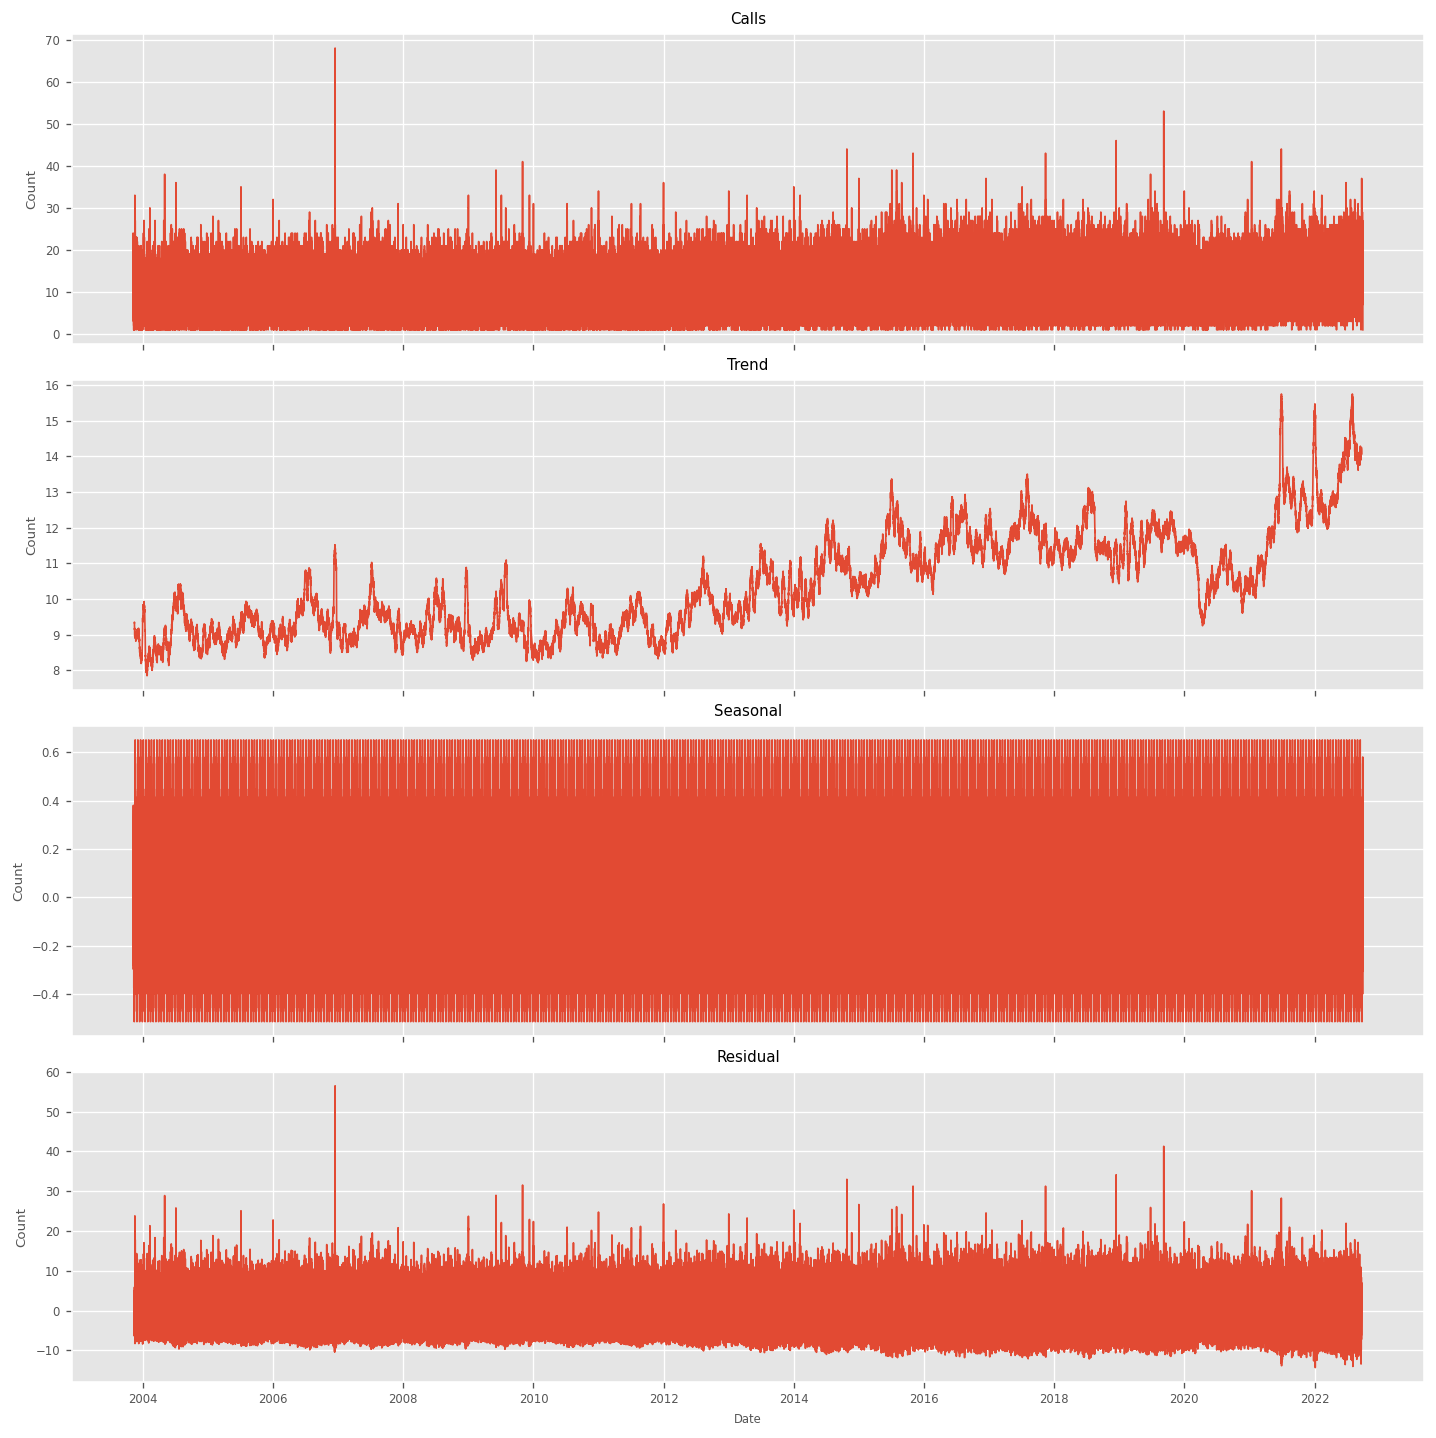

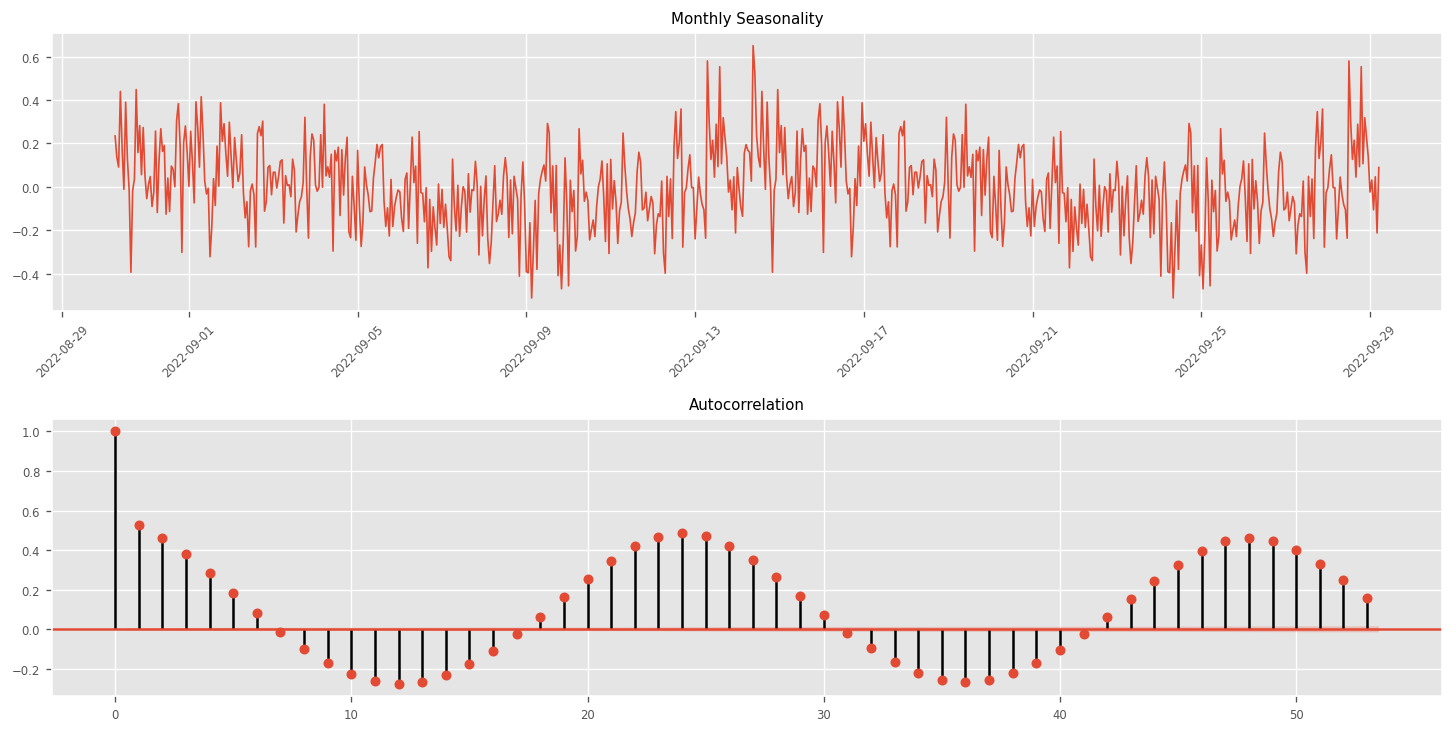

In [53]:
seasonal_analysis(train_df, 'calls', period=365)

*   **The plots show that there is a increasing trend in call volume up to 2018-2019, and sudden drop after 2020. The main reason is the quarantine/self-quarantine period due to pandemic.** 
*   **Since staying home reduces the risk of fire, the decrease makes sense. Likewise, after lifting the restrictions, there were many events, festivals, and concerts which made the people go outside, use transportation, etc., that resulted in an enormous increase in call volume.**
*   **Seasonality and autocorrelation plots show that using past information such as 12 hours before, 24 hours before, also week and month before as features might be useful to learn patterns of the call data.**



> 🌂**Next, weather data is investigated to see correlation of the weather and call volume in a better way. To see similarities better, daily call volume limited to 450.**

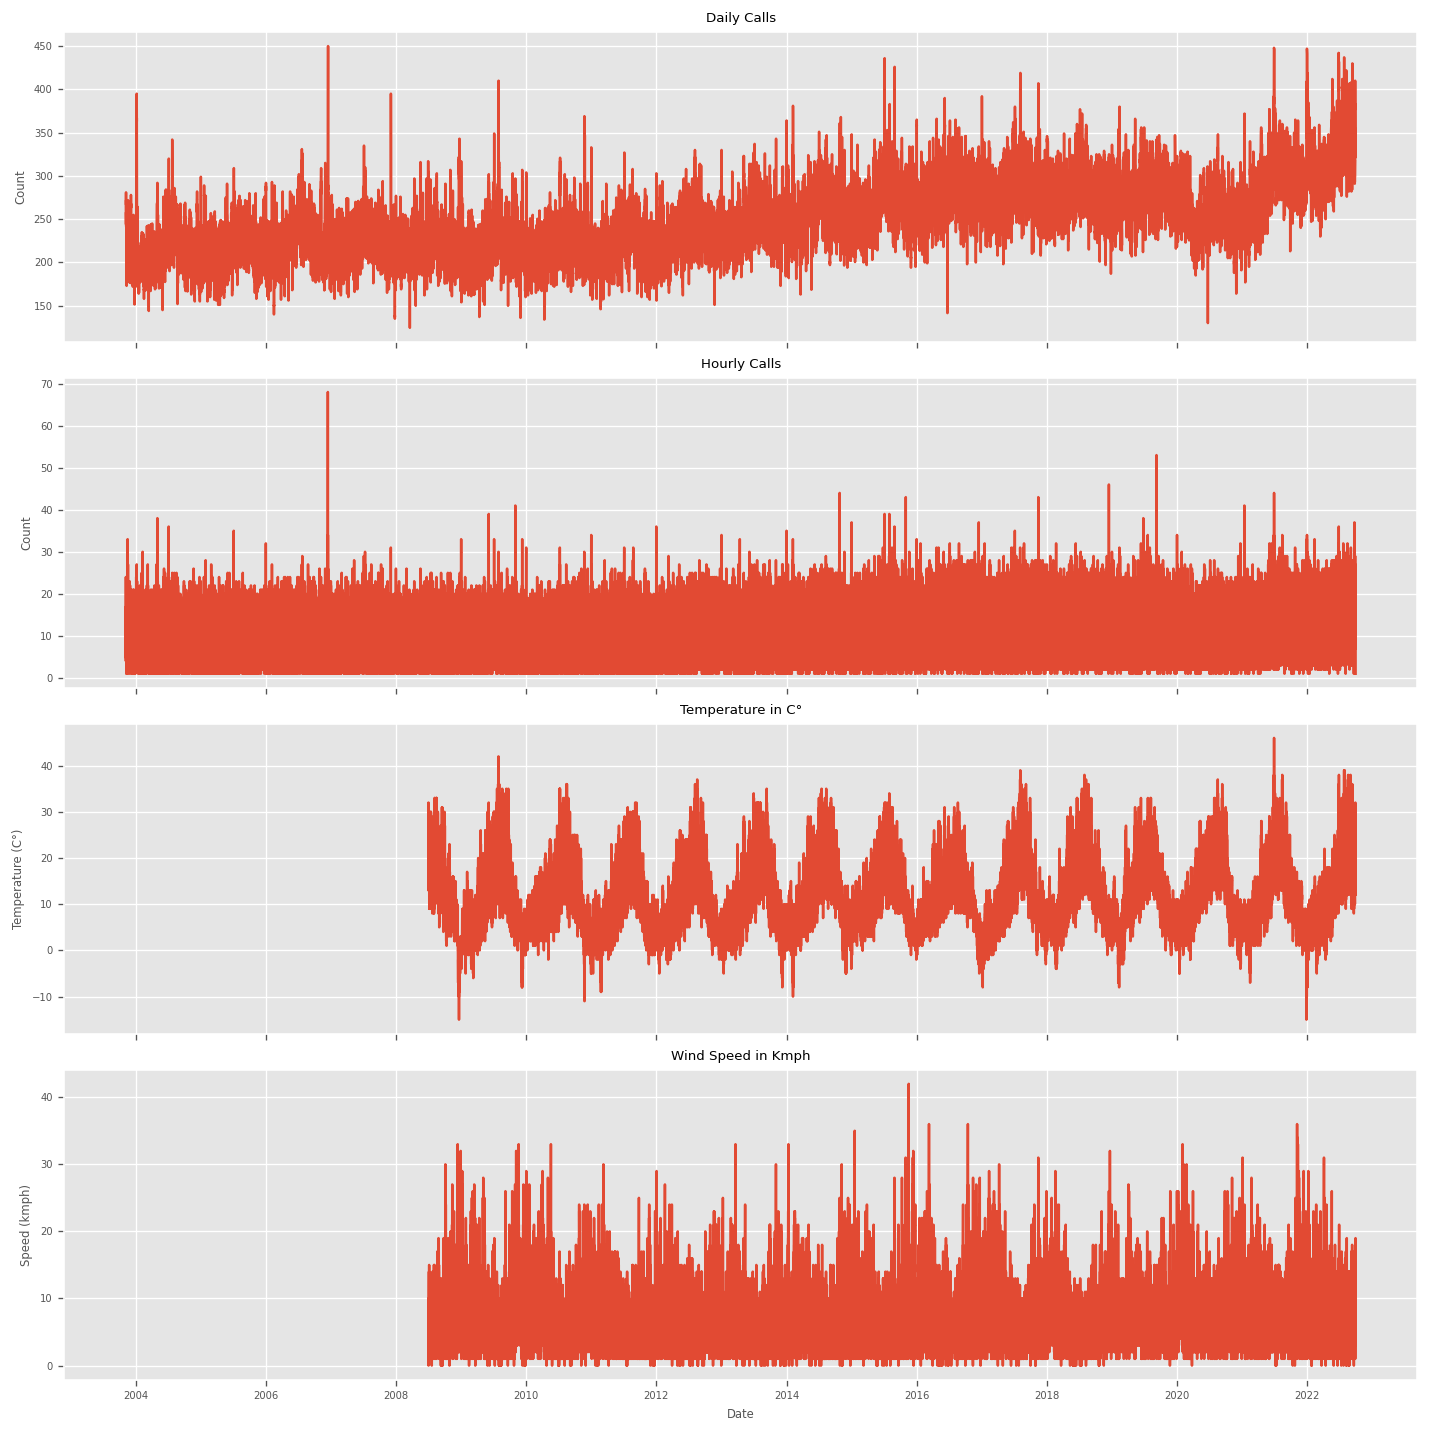

In [54]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
axs[-1].set_xlabel('Date', fontsize=7)
fig.tight_layout() # for titles

data_dict = {'Daily Calls':daily_calls[daily_calls <= 450], 'Hourly Calls':hourly_calls, \
             'Temperature in C°':train_df.tempC,
             'Wind Speed in Kmph':train_df.windspeedKmph}
labels = ['Count', 'Count', 'Temperature (C°)', 'Speed (kmph)']

for ax, label, data in zip(axs.flat, labels, data_dict):    
    ax.set_title(data, fontsize=8)
    ax.set_ylabel(label, fontsize=7)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.plot(data_dict[data])


> **The plots show that using temperature data as a feature might be useful, but it is hard to say the same for wind speed. It changes quite a lot in hourly resolution unlike the temperature, probably ocean affects the wind.** 

> **Seaborn heatmap is a good way to visualize correlations. There are 16 features and 1 target variable: calls. Hour, year, tempC, and the rolling window mean values have higher correlation than the others. It seems there is nearly no correlation between call volume and day of week, day of month, quarter, and month.**

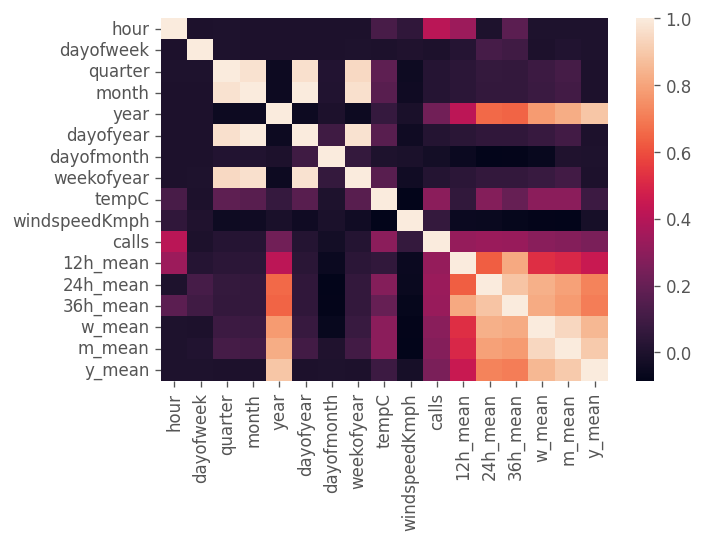

In [55]:
import seaborn as sns

sns.heatmap(train_df.corr());

# Base Model, Feature Selection, Training, Testing, and Predicting

> **Setting start date to 2008-09-15, because weather data is available after 2008-07-15. For baseline model, basic features are used such as time features. select_feat parameter can be used to enable Recursive Feature Elimination during training, which increase the performance of the model (but not always).**

> **There are plenty of possibilites to use for time series such as AR, MA, ARIMA, SARIMA, then also recent powerful models like ANN, LSTM... For this project, Gradient Boosting Regression Tree is used (also suggested). It is also clear that the data is not stationary since the mean and variance are not constant. Making it stationary is required particularly for AR forecasting models. In addition, linear regression works best if the predictors are not correlated. Note that, the data is time series, there will be no shuffling the data in anyway.**

In [57]:
base_df = train_df.iloc[:, :8].merge(train_df.calls, left_index=True, 
                                     right_index=True)
base_res = train(base_df, target='calls', select_feat=False)

[13:00:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.91872	validation_1-rmse:12.7788
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:3.46942	validation_1-rmse:4.11869
[200]	validation_0-rmse:3.44442	validation_1-rmse:4.11079
Stopping. Best iteration:
[180]	validation_0-rmse:3.4471	validation_1-rmse:4.10448

RMSE: 4.104484558105469


In [58]:
base_df.columns

Index(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'calls'],
      dtype='object')

> **Now, weather data is added to baseline dataset. Since windspeedKmph reduces the performance by a large margin, it is discarded. Note that, temperature data provided also reduces the performance, but it decreases the error on train set (validation_0-rmse) which shows the correlation between call volume and weather data.**

In [ ]:
# with weather data
base_df = train_df.iloc[:, :11].drop(columns=['windspeedKmph'])
base_res = train(base_df, target='calls', select_feat=False)

[17:23:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.2592	validation_1-rmse:12.6875
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:3.50696	validation_1-rmse:4.15918
[200]	validation_0-rmse:3.47484	validation_1-rmse:4.11354
[300]	validation_0-rmse:3.46188	validation_1-rmse:4.10112
Stopping. Best iteration:
[342]	validation_0-rmse:3.45787	validation_1-rmse:4.09302

RMSE: 4.093018054962158


In [ ]:
base_df.columns

Index(['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'tempC', 'calls'],
      dtype='object')

> **Other features are added to train set, which significantly increase the performance of the regressor. It was expected thanks to seasonality and autocorrelation analysis.** 

In [ ]:
fitted_model, preds, test_data = train(train_df.drop(columns=['windspeedKmph']), 
                                       target='calls', start=start_from, 
                                       end=end_date, select_feat=False)

[18:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.2552	validation_1-rmse:12.6366
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:3.32423	validation_1-rmse:3.73726
Stopping. Best iteration:
[117]	validation_0-rmse:3.31523	validation_1-rmse:3.73187

RMSE: 3.7318718433380127


> **Setting `select_feat=True` to use RFE algorithm to select most effective features yields a quite good result, decreasing the RMSE to ~3.669. Unfortunately, it takes long time particularly when input is large.**

In [ ]:
fitted_model, preds, test_data = train(train_df.drop(columns=['windspeedKmph']), 
                                       target='calls', start=start_from, 
                                       end=end_date, select_feat=True)

[17:29:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

> **The features selected by the RFE algorithm...**

In [ ]:
fitted_model.get_booster().feature_names

['hour', 'dayofweek', 'year', 'dayofyear', 'tempC', '12h_mean', '24h_mean']

> **For the sake of completeness, k-fold cross-validation for time series is shown below. This would be useful particularly comparing many models in a subset of dataset.**

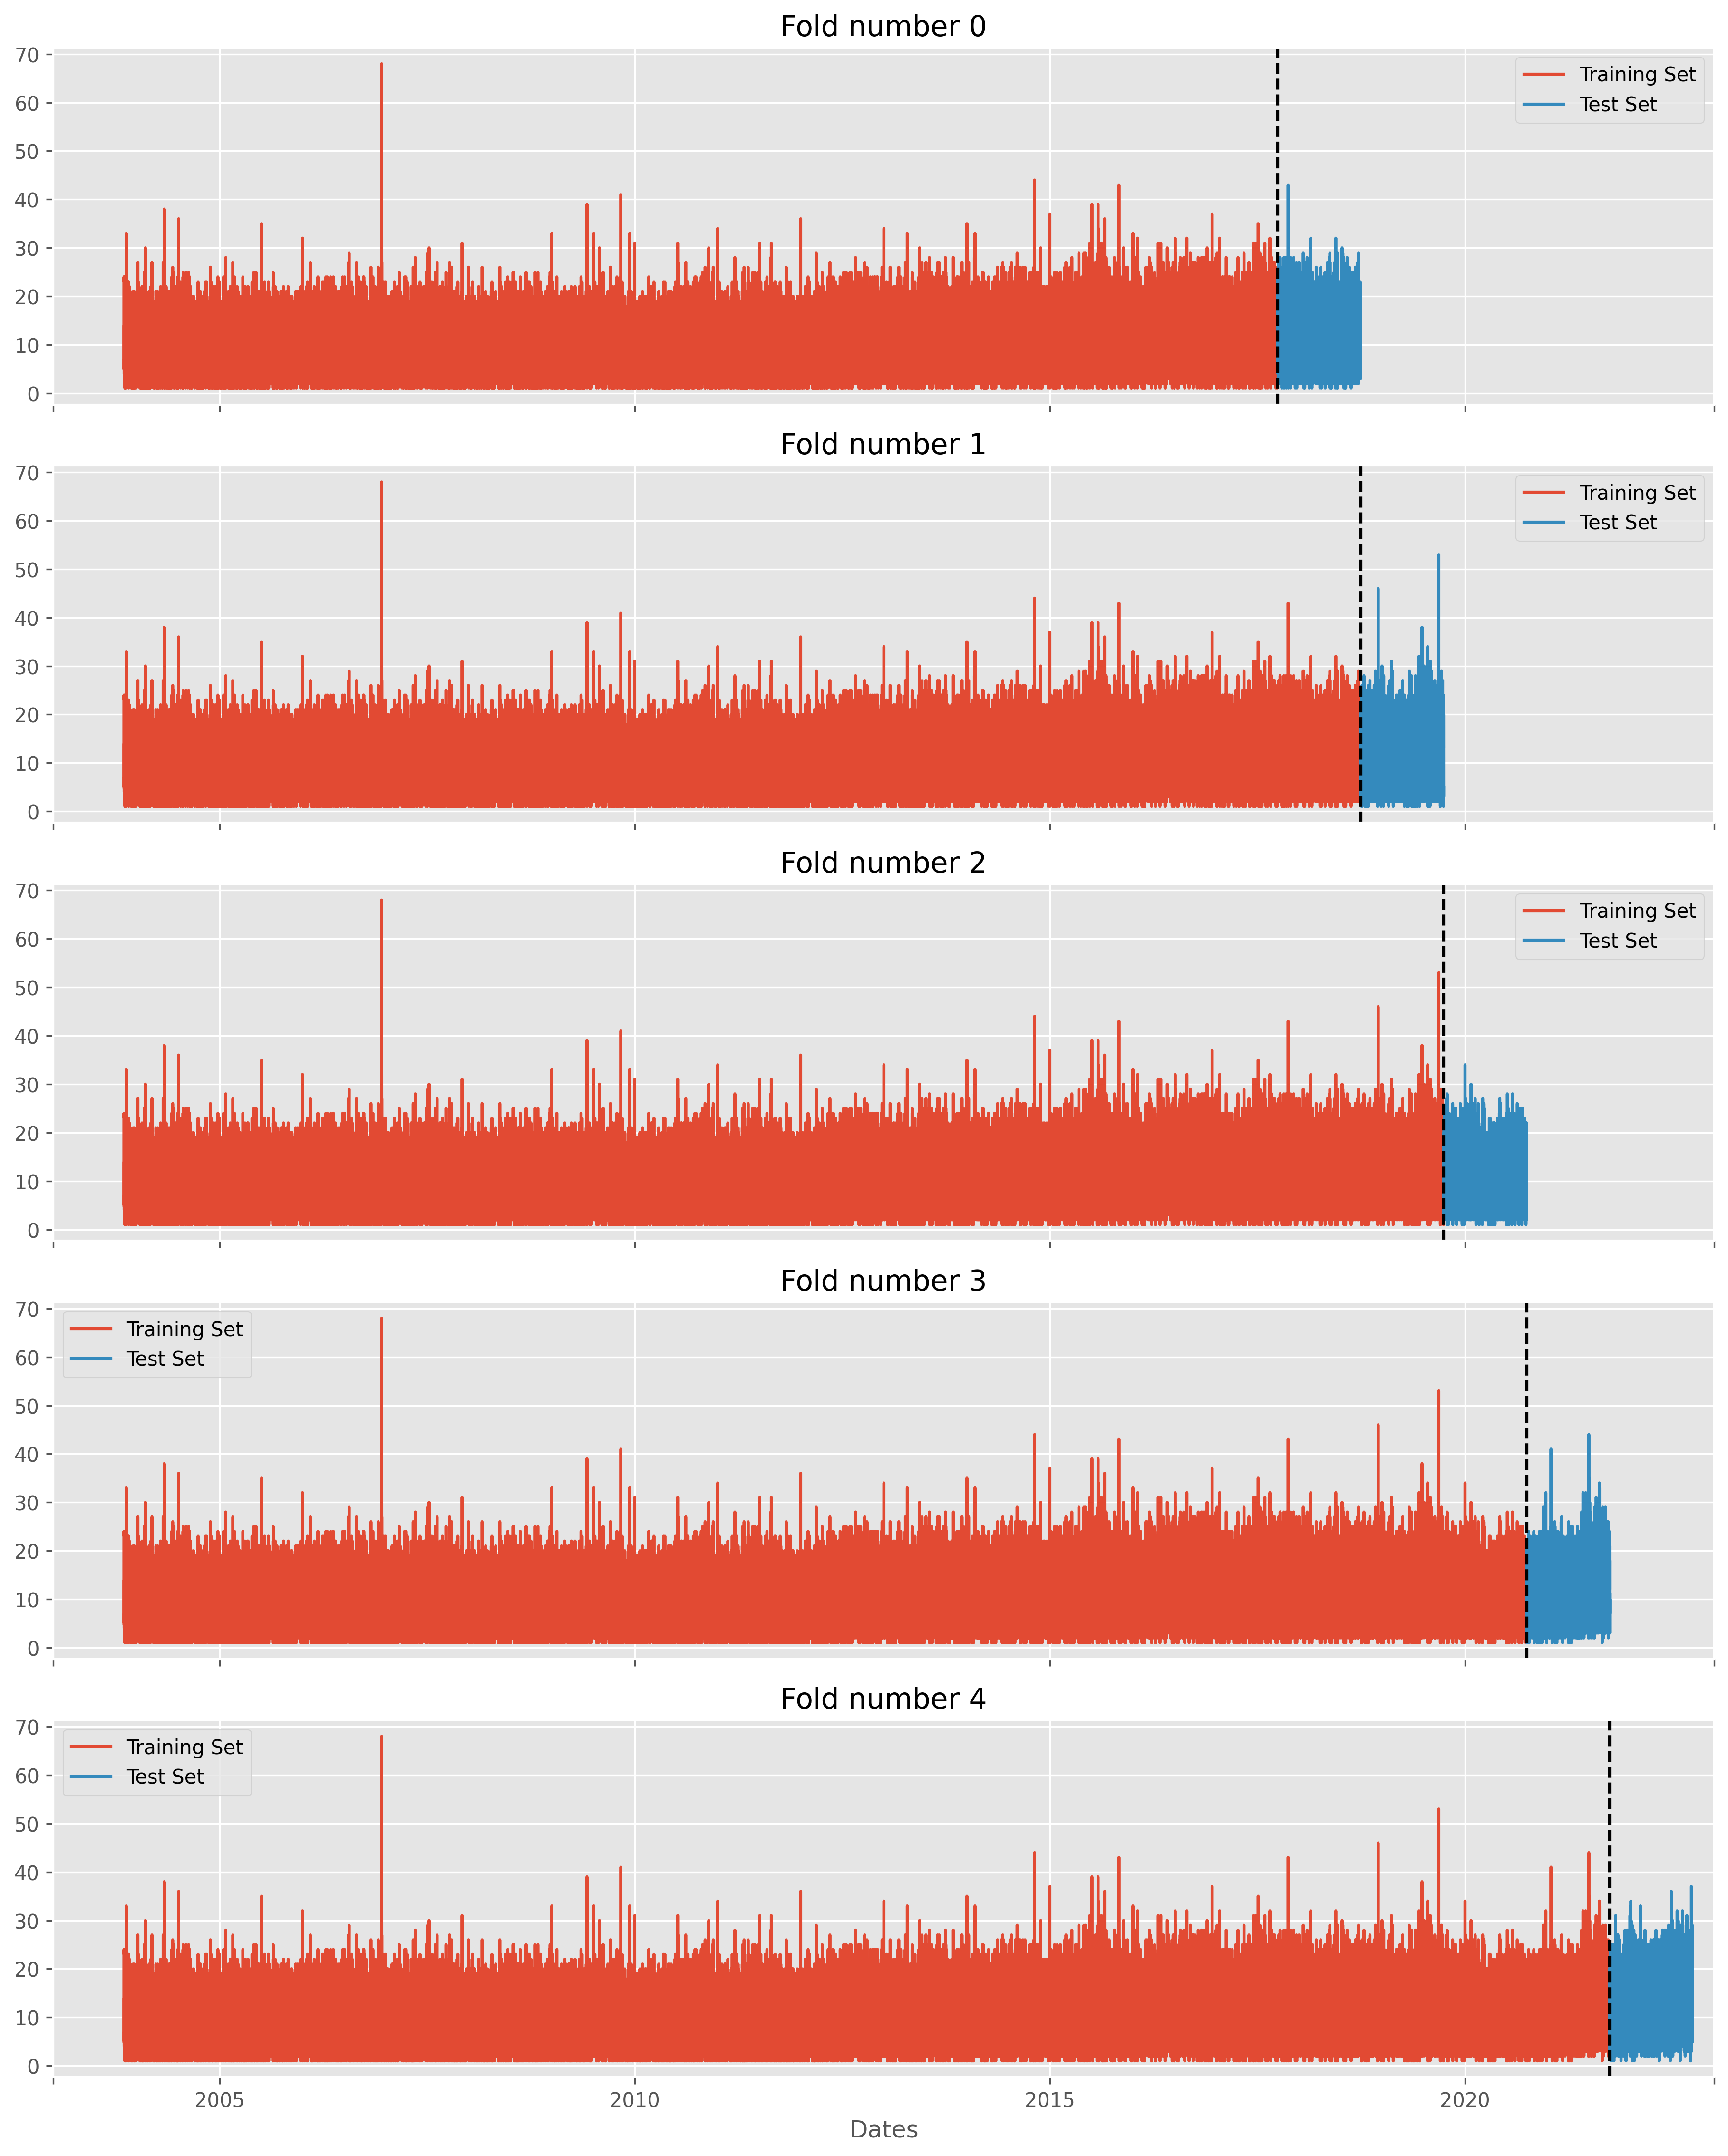

In [ ]:
#@title K-fold plot

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365)
# train_df.sort_index(inplace=True)
fig, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True, 
                        constrained_layout=True)
fold = 0

for train_idx, val_idx in tss.split(train_df):
    train = train_df.iloc[train_idx]
    test = train_df.iloc[val_idx]
    train['calls'].plot(ax=axs[fold], 
                        label='Training Set',
                        title=f'Fold number {fold}')
    test['calls'].plot(ax=axs[fold],
                       label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend(['Training Set', 'Test Set'])
    axs[fold].tick_params(axis='x', which='minor', bottom=False)
    axs[fold].set_xlim(['2003-01-01', '2023-01-01'])
      
    fold += 1

axs[fold-1].set_xlabel('Dates')  
plt.savefig('kfold_plot.png')
# plt.show()

> **To obtain better predictions, a portion of the data will be used to train the model (which was also suggested). Using the data between 2016-09-20 to 2022-09-20 to train the model by splitting last 1 year's data (2021-2022), which will be used to validate/test.**

In [ ]:
train_df.drop(columns=['windspeedKmph'], inplace=True)

In [ ]:
sdate = '2016-09-20'
edate = '2022-09-20' 

fitted_model, preds, test_data = train(train_df, target='calls', start=sdate, 
                                       end=edate, select_feat=False)

[18:02:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.0486	validation_1-rmse:12.6343
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:3.44593	validation_1-rmse:3.71915
Stopping. Best iteration:
[72]	validation_0-rmse:3.46574	validation_1-rmse:3.70741

RMSE: 3.707411289215088


> **Once again, selected features yield lower RMSE. In this case the elimination process takes shorter time since the dataset is smaller.**

In [ ]:
fitted_model, preds, test_data = train(train_df, target='calls', start=sdate, 
                                       end=edate, select_feat=True)

[18:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

> **train() function supports cross-validation. Setting `cv=True` one can train the model with cross-validation. Note that, RFE algorithm is not available in this case, since it might have selected different features for each fold.**

In [ ]:
_, _, _ = train(train_df, target='calls', start=sdate, end=edate, cv=True)

[18:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.3089	validation_1-rmse:11.2002
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:3.4089	validation_1-rmse:3.52189
Stopping. Best iteration:
[118]	validation_0-rmse:3.3895	validation_1-rmse:3.5177

[18:16:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.2586	validation_1-rmse:11.0624
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:3.44512	validation_1-rmse:3.55311
[200]	validation_0-rmse:3.38626	validation_1-rmse:3.55403
Stopping. Best iteration:
[161]	validation_0-rmse:3.4058	val

> **The results also show that the model has the worst prediction performance for the last year, but it can fit really well the data in the 3rd fold, which is data between 2019-2020. Note that the last RMSE is the same with previous result obtained without feature selection, as it should be.**

In [ ]:
def plot_results(test_data, pred):
    """
    Plots the actual and prediction data, both hourly and daily.

    Parameters
    ----------
    test_data: pandas.DataFrame
        Should include features and target variable.
    pred: array
        Predictions of the model.
    """ 
    
    hourly_pred_lastyear = pd.DataFrame(
        {"Calls": test_data, "BestPrediction": pred}
    )
    plt.style.use('ggplot')

    # fig = plt.figure(figsize=(25,8))
    # hourly_pred_lastyear.plot(ylabel='Call Counts', 
    #          title='Hourly Call Data Prediction', fontsize=6)
    
    # fig = plt.figure(figsize=(25,8))
    # hourly_pred_lastyear.Calls.rolling(24).sum()\
    #     .plot(label="Actual", linewidth=2, 
    #           xlabel='Date', ylabel='Call Counts')
    # hourly_pred_lastyear.BestPrediction.rolling(24).sum()\
    #     .plot(label="Prediction", linewidth=2, title='Daily Call Data Prediction', 
    #           xlabel='Date', ylabel='Call Counts')


    fig, axs = plt.subplots(3, 1, figsize=(12,9), sharex=True)
    axs[0].plot(hourly_pred_lastyear, lw=1)
    axs[0].set_ylabel('Hourly Call Count', fontsize=7)
    axs[0].legend(['Actual', 'Prediction'])

    axs[1].plot(hourly_pred_lastyear.rolling(24).sum(), lw=1)
    axs[1].set_ylabel('Daily Call Count', fontsize=7)
    axs[1].legend(['Actual', 'Prediction'])

    axs[2].plot(hourly_pred_lastyear.rolling(24*7).sum(), lw=1)
    axs[2].set_ylabel('Weekly Call Count', fontsize=7)
    axs[2].legend(['Actual', 'Prediction'])

    [ax.tick_params(axis='both', which='major', labelsize=6) for ax in axs];

> ❎**Base model performance can be observed from the figures below. Notice that after 2022-01, the model underestimate the call counts and cannot catch the data up to 2022-07. Even if it shows a relatively better performance after 7th month, the daily and weekly data indicates that the model is not suitable to use as it is.**

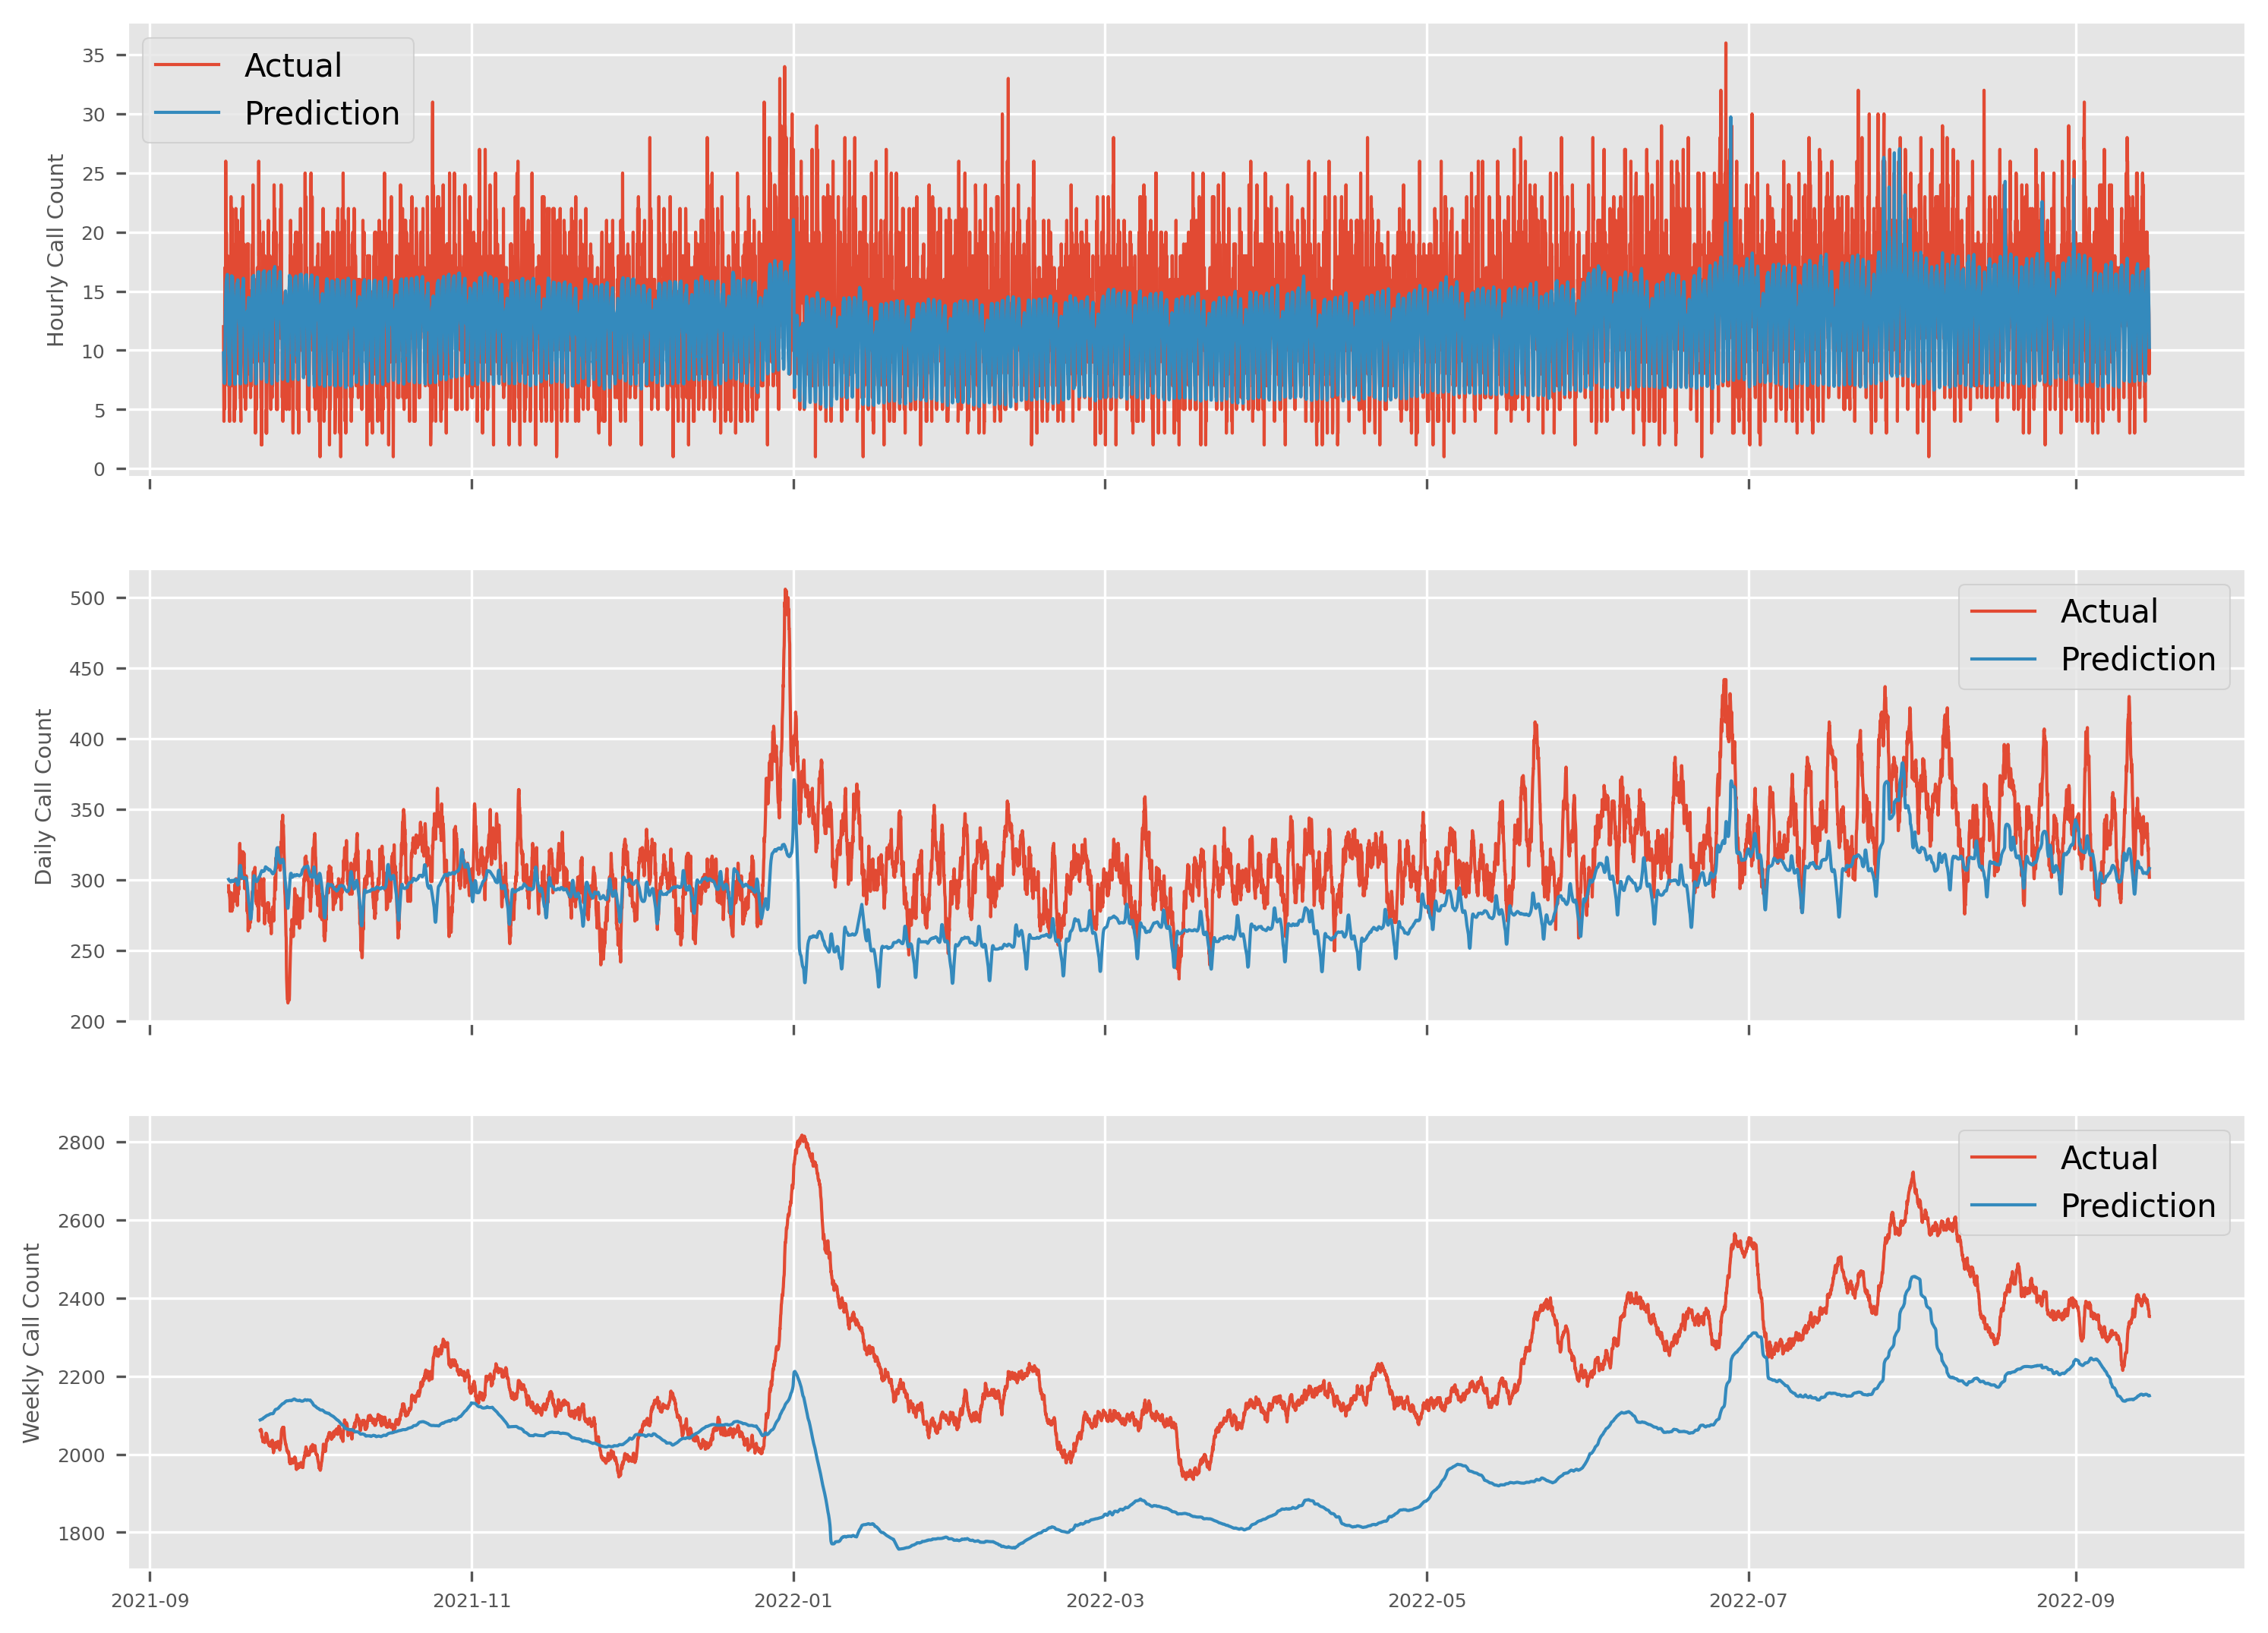

In [ ]:
plot_results(base_res[2].calls, base_res[1])

> ✅**The model which is trained with selected features by RFE algorithm yields much better results, as observed from the figures below. In the hourly call prediction plot, it is easy to notice the difference with the base model. The real performance of the model is indicated in the second and third plots. It is significantly better in predicting daily and weekly call counts than the base model. Note that, new year eve and the week before/after has unusual call volume. This is also observed in other years. Adding a feature considering this cyclic behavior might have further increase the performance of the model, which can be considered as a future (feature :) ) work.**

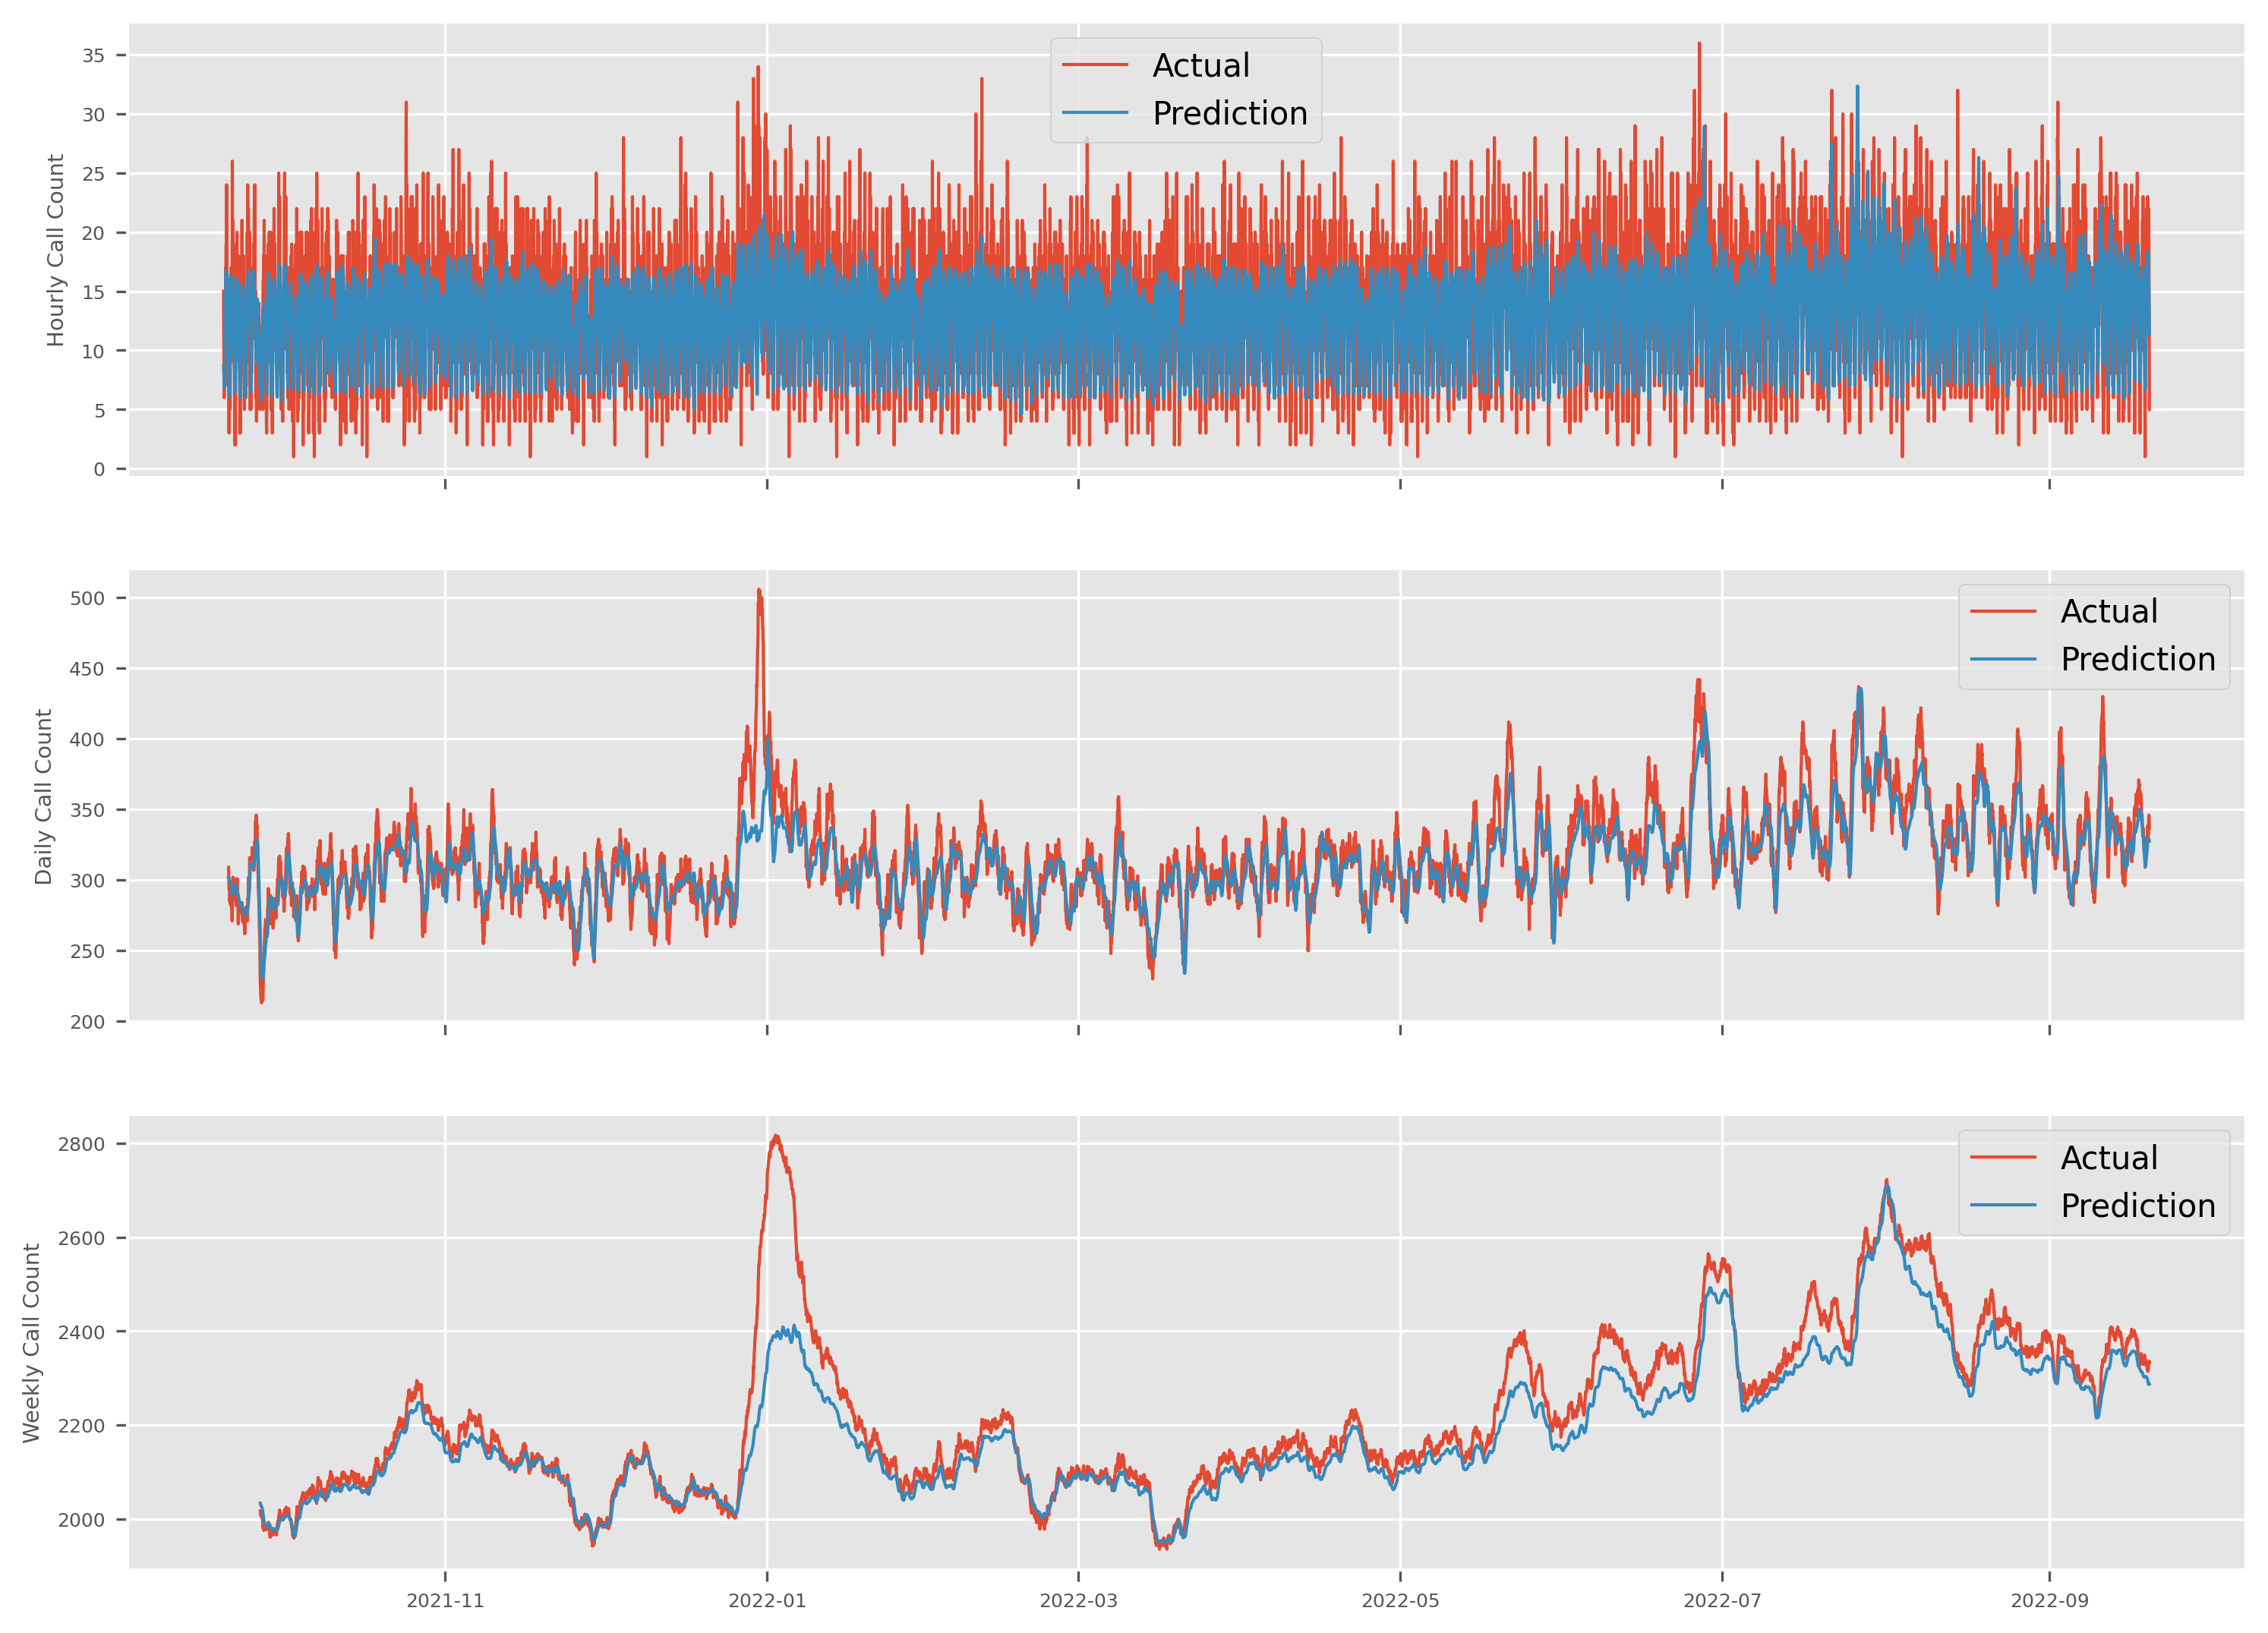

In [ ]:
plot_results(test_data.calls, preds)


> **To test a model with a subset of the dataset, test() function might be used.**

In [ ]:
def test(model, test_data, target=None): 
    """
    Predicts call volume, for subset of the dataset.

    Parameters
    ----------
    model : XGBRegressor() instance
    test_data: pandas.DataFrame
        Should include features and target variable.
    target: str
        Target variable column name in the test_data.    
    
    Returns
    -------
    y_pred : array
        Call volume predictions.
    score: float
        RMSE for the given test set.
    """ 

    if target:
        features = model.get_booster().feature_names
        x_test = test_data[features]
        y_test = test_data[target]
    else:
        print("Use predict.py if you do not provide target variable.")
        return
    
    y_pred = model.predict(x_test)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {score}')
    
    return y_pred, score

In [ ]:
test(fitted_model, test_data.iloc[-300:], target='calls')[1]

RMSE: 3.5724761486053467


3.5724761

> **To make a prediction out of the dataset dates, predict() function can be used. It takes a trained model, two dates, and frequency which is used to set resolution of time stamps. It returns a DataFrame with dates as index and predicted call volume.**

In [ ]:
from preprocess import DataSet

def predict(model, start_date, end_date, freq='H'):  
    """
    Predicts a future call volume, for a date/period out of the dataset.

    Parameters
    ----------
    model : XGBRegressor() instance
    start_date : str
        Date in %Y-%M-%D format.
    end_date : str
        Date in %Y-%M-%D format.
    freq: str
        Any frequency from ['H', 'D', 'W', 'M']
    
    Returns
    -------
    y_pred : pandas.DataFrame
        Call volume predictions with date index.
    """
    
    assert end_date > start_date, "Provide end date which is LATER than start!"
    assert freq in ['H', 'D', 'W', 'M'], \
        "Frequency can be 'H', 'D', 'W', 'M' !!"

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    indexer = pd.date_range(start=start_date, end=end_date, freq='H')

    df = pd.DataFrame(columns=model.get_booster().feature_names)
    df = df.reindex(indexer)
    df.index.name = 'stamp'
    df['stamp'] = df.index

    test_ds = DataSet(df)
    test_ds.add_time_features()
    test_df = test_ds.df.drop(columns=['hour_only'])
    test_df = test_df.astype('float32')

    y_pred = model.predict(test_df)
    y_pred = pd.DataFrame(y_pred ,index=test_df.index)
    y_pred.columns = ['Calls']
    
    if freq == 'D':
        y_pred = y_pred.resample('1D').sum()
    elif freq == 'W':
        y_pred = y_pred.resample('7D').sum()
    elif freq == 'M':
        y_pred = y_pred.resample('30D').sum()

    return y_pred


In [ ]:
predict(base_res[0], '2023-09-19', '2024-08-07', freq='D')


,Calls
stamp,
2023-09-19,309.104980
2023-09-20,311.449493
2023-09-21,314.572296
2023-09-22,318.685303
2023-09-23,313.392639
...,...
2024-08-03,321.497131
2024-08-04,301.622528
2024-08-05,307.128723
